# TL;DR (Base model):

Classification is based on LSTM with some hyperparameter optimization. This is our base model.
$F_1$ score (on dev set) = $0.321$
$Recall$ score (on dev set) = $0.312$

- We chose RNN because the data is sequential, therefore we assume that each row has an impact on the next row (in other words, context).
- The loss is a binary cross entropy loss, which is particularly good in our case: an unbalanced training set.
- We used resampling (specifically random oversampling) to deal with the imbalance.
- We also measured $Recall$ (besides $F_1$) because this score proves itself when it comes to medical data and risk of death (by definition, we want to be sure that we didn't miss people who could go at any moment.
- We normalized (mean and std) the data to fit our model better.
- We impute missing data for each patient by similar (e.g. closest) values, a linear interploation backward and forward. In special cases (no cells to copy from) we fill with the mean value of the column.
- As we observed in the analysis, the average time a patient Was in ICU is about 20 hours. In our last run, we used $12$ as our num of rows (taken from tail = last hours).
- Regularization: Dropout, $p=0.75$ (trial and error).
- We didn't use all the features (for more details, please check <code>Analysis.ipynb</code>.

# Preprocessing:

We work with part of the columns, based on our analysis and further reading. Demographics didn't help to fit our model (actually, the results were better without it) so we dropped those columns. We used some lab-test results that seems to distribute different based on <code>SepsisLabel</code> as we saw in plots and stats.

In [1]:
from Analysis.utils import concat_data, scale_train_data
from LSTM_Classifier.utils import transform_trim, zip_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import importlib

In [2]:
columns = ["HR", "O2Sat", "Temp", "MAP", "Resp", "AST", "BUN",
           "Alkalinephos", "Calcium", "Creatinine", "Glucose", "Bilirubin_total",
           "Hgb", "PTT", "WBC", "Fibrinogen", "Platelets"]

In [3]:
df = concat_data(src_dir='Data/sliced/train', dst_dir='LSTM_Data', name='train', impute='lstm')
# df = pd.read_csv('LSTM_Data/train_concatenated.csv', index_col=0)

100%|██████████| 20000/20000 [01:47<00:00, 186.68it/s]


In [4]:
tdf = transform_trim(df, columns, r=12)
transformed_df = tdf.copy()

100%|██████████| 20000/20000 [00:19<00:00, 1005.46it/s]


In [5]:
transformed_df.head()

,HR,O2Sat,Temp,MAP,Resp,AST,BUN,Alkalinephos,Calcium,Creatinine,Glucose,Bilirubin_total,Hgb,PTT,WBC,Fibrinogen,Platelets,PatientID
0,60.0,94.0,36.110000,74.0,12.0,130.972427,100.0,95.728976,7.9,2.5,78.0,1.426839,9.7,35.901121,11.0,308.205753,158.0,0
1,62.0,95.0,36.110000,72.0,12.0,130.972427,100.0,95.728976,7.9,2.5,78.0,1.426839,9.7,35.901121,11.0,308.205753,158.0,0
2,63.0,95.0,36.110000,75.0,11.0,130.972427,100.0,95.728976,7.9,2.5,78.0,1.426839,9.7,35.901121,11.0,308.205753,158.0,0
3,63.0,97.0,36.110000,81.0,11.0,130.972427,100.0,95.728976,7.9,2.5,78.0,1.426839,9.7,35.901121,11.0,308.205753,158.0,0
4,58.0,94.0,36.073333,58.0,10.0,130.972427,100.0,95.728976,7.9,2.5,78.0,1.426839,9.7,35.901121,11.0,308.205753,158.0,0


Save feature means (for later use in test):

In [6]:
means = transformed_df.mean()
means.to_csv('LSTM_Data/train_means.csv')

Normalize the data ($-\mu$ $\hspace{2mm}$ $/\sigma$):

In [7]:
# Normalize:
X = scale_train_data(transformed_df, method='standard', path='LSTM_Data')
X['PatientID'] = transformed_df['PatientID']

In [8]:
X.to_csv('LSTM_Data/train_ready_to_go.csv') # X = pd.read_csv('LSTM_Data/train_ready_to_go.csv', index_col=0)

<code>labels.loc[id]</code> returns the label of <code>patient_id.psv</code>:

In [9]:
labels = pd.read_csv('Data/sliced/train_labels.csv', index_col=0)

Prepare the data for our sequence model. We'll feed our model with the following tuples (features, label, patient_id). patient_id isn't really necessary for training, except for the last part (exporting labels CSV file) so get things ready now (Later, we'll build our custom Dataset class and use it).

In [10]:
sequences = zip_sequences(X, labels, columns)

In [11]:
train_sequences, val_sequences = train_test_split(sequences, test_size=0.2 , shuffle=True)
print("Training size: {},\tValidation size: {}.".format(len(train_sequences), len(val_sequences)))

Training size: 16000,	Validation size: 4000.


# Resampling (oversampling):

Random over-sampling, we sampled 1600 samples from the minor class. We didn't add noise to generate new samples and mitigate overfitting just because the values are sensitive it could do more hurt than good.

In [12]:
from sklearn.utils import resample

In [13]:
positive_idx = [i for i, seq in enumerate(train_sequences) if int(seq[1]) == 1]
positive_sequences = [train_sequences[i] for i in positive_idx]

In [14]:
negative_idx = [i for i in range(len(train_sequences)) if i not in positive_idx]
negative_sequences = [train_sequences[i] for i in negative_idx]

In [15]:
resampled_sequences = train_sequences + resample(positive_sequences, n_samples=1600, random_state=42)

# Dataset:

We implement our own custom DataSet (for PyTorch). Our full implementation can be found in <code>LSTM_Classifier.SepsisDataset</code>.

In [16]:
from torch.utils.data import DataLoader
from LSTM_Classifier.SepsisDataset import SepsisDataset

In [17]:
train_dataset = SepsisDataset(train_sequences)
resampled_dataset = SepsisDataset(resampled_sequences)
val_dataset = SepsisDataset(val_sequences)

In [18]:
BATCH_SIZE = 64

In [19]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
resampled_loader = DataLoader(dataset=resampled_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model

LSTM of size 100/64 with 4/6 layers and. Dropout regularization of $p=0.75/0.7$ (found it useful), optimized with Adam optimization algorithm. We took the one who gave the highest score of course. These initial hyper-parameters are nothing more than a guess.
Model implementation can be found in <code>LSTM_Classifier.SequenceModel</code>. We tried both methods, with resampled data and without.

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from LSTM_Classifier.SequenceModel import SequenceModel

In [21]:
NUM_EPOCHS = 20
LEARNING_RATE = 0.001

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
model1 = SequenceModel(n_features=len(columns), n_hidden=100, n_layers=4, dropout=0.75)
model1.to(device)
model2 = SequenceModel(n_features=len(columns), n_hidden=100, n_layers=4, dropout=0.75)
model2.to(device)
model3 = SequenceModel(n_features=len(columns), n_hidden=64, n_layers=6, dropout=0.7)
model3.to(device)
model4 = SequenceModel(n_features=len(columns), n_hidden=64, n_layers=6, dropout=0.7)
model4.to(device)
model5 = SequenceModel(n_features=len(columns), n_hidden=64, n_layers=7, dropout=0.65)
model5.to(device)
models = [model1, model2, model3, model4, model5]

# Training

Cross entropy loss is known as a useful in case of imbalanced data, that's our case.

In [29]:
def train(model, data_loader, criterion = nn.BCEWithLogitsLoss()):
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    f1_scores = []
    recall_scores = []
    for epoch in range(NUM_EPOCHS):
        TP, FP, FN = 0, 0, 0
        for i, (sequences, labels, _) in enumerate(data_loader):
            # Send data to device:
            sequences = sequences.to(device)
            labels = labels.to(device)
            # Set all gradients to zero:
            optimizer.zero_grad()
            # Calculate loss and backprop:
            outputs = model(sequences)
            loss = criterion(outputs, labels.to(torch.float32))
            loss.backward()
            optimizer.step()
#             # Show progress:
#             if i % 30 == 0:
#                 print ('Epoch: [{}/{}], Step: [{:03d}/{}], Loss: {:.2}'
#                        .format(epoch+1, NUM_EPOCHS, i+1, len(train_dataset)//BATCH_SIZE, loss.item()))
            predictions = torch.where(torch.sigmoid(outputs)>0.5, 1, 0)
            for j in range(labels.shape[0]):
                if labels[j] == 0:
                    if predictions[j] == 1:
                        FP += 1
                else:
                    if predictions[j] == 1:
                        TP += 1
                    else:
                        FN += 1
        print("Counted:\t\tTP={}\tFP={}\tFN={}".format(TP, FP, FN))
        f1_scores.append(TP/(TP+0.5*(FP+FN)))
        recall_scores.append(TP/(TP+FN))
    return f1_scores, recall_scores

In [30]:
titles = ['($\ell=4, n_h=100, p=0.75$) no resampling',
          '($\ell=4, n_h=100, p=0.75$) oversampling',
          '($\ell=6, n_h=64, p=0.7$) no resampling',
          '($\ell=6, n_h=64, p=0.7$) oversampling',
          '($\ell=7, n_h=64, p=0.65$) oversampling']
loaders = [train_loader, resampled_loader, train_loader, resampled_loader, resampled_loader]
f1 = []
recall = []

We can see on the prints below the <code>TP</code>, <code>FP</code>, <code>FN</code> stats every epoch and see how effective is the random oversampling. While the regular train set missed almost every possible prediction, the resampled train predicted right. This is not a fact, we will evaluate later:

In [31]:
for i in range(len(models)):
    print('\n\n\n---------------\t'+titles[i]+'\t---------------')
    f1_scores, recall_scores = train(models[i], loaders[i])
    f1.append(f1_scores)
    recall.append(recall_scores)




---------------	($\ell=4, n_h=100, p=0.75$) no resampling	---------------
Counted:		TP=9	FP=47	FN=1140
Counted:		TP=0	FP=0	FN=1149
Counted:		TP=0	FP=1	FN=1149
Counted:		TP=22	FP=10	FN=1127
Counted:		TP=143	FP=43	FN=1006
Counted:		TP=150	FP=25	FN=999
Counted:		TP=141	FP=13	FN=1008
Counted:		TP=170	FP=37	FN=979
Counted:		TP=165	FP=31	FN=984
Counted:		TP=187	FP=32	FN=962
Counted:		TP=225	FP=73	FN=924
Counted:		TP=249	FP=61	FN=900
Counted:		TP=289	FP=113	FN=860
Counted:		TP=302	FP=119	FN=847
Counted:		TP=342	FP=129	FN=807
Counted:		TP=375	FP=131	FN=774
Counted:		TP=400	FP=158	FN=749
Counted:		TP=431	FP=144	FN=718
Counted:		TP=460	FP=148	FN=689
Counted:		TP=483	FP=159	FN=666



---------------	($\ell=4, n_h=100, p=0.75$) oversampling	---------------
Counted:		TP=4	FP=8	FN=2745
Counted:		TP=249	FP=190	FN=2500
Counted:		TP=732	FP=318	FN=2017
Counted:		TP=852	FP=390	FN=1897
Counted:		TP=990	FP=436	FN=1759
Counted:		TP=1174	FP=511	FN=1575
Counted:		TP=1270	FP=501	FN=1479
Counted:		TP=1383	FP

In [34]:
for i in range(len(models)):
    print('---------------------------------')
    print(titles[i]+':\n')
    print("\tF1:\t\t", f1[i][-1])
    print("\tRecall:\t\t", recall[i][-1])

---------------------------------
($\ell=4, n_h=100, p=0.75$) no resampling:

	F1:		 0.5393634840871022
	Recall:		 0.42036553524804177
---------------------------------
($\ell=4, n_h=100, p=0.75$) oversampling:

	F1:		 0.817096649980747
	Recall:		 0.7719170607493634
---------------------------------
($\ell=6, n_h=64, p=0.7$) no resampling:

	F1:		 0.292166549047283
	Recall:		 0.1801566579634465
---------------------------------
($\ell=6, n_h=64, p=0.7$) oversampling:

	F1:		 0.7409823484267076
	Recall:		 0.7024372499090579
---------------------------------
($\ell=7, n_h=64, p=0.65$) oversampling:

	F1:		 0.7889692939565812
	Recall:		 0.7337213532193525


In [35]:
import matplotlib.pyplot as plt

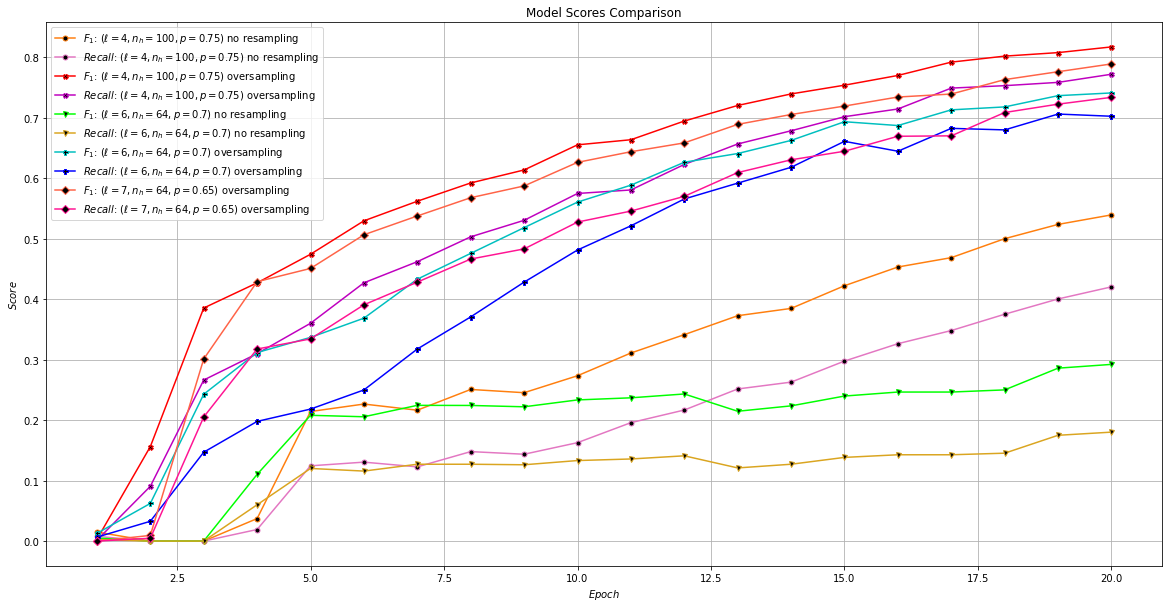

In [36]:
x = range(1,NUM_EPOCHS+1)
_ = plt.figure(figsize=(20, 10))
colors = [['tab:orange', 'tab:pink'], ['r', 'm'], ['lime', 'goldenrod'], ['c', 'b'], ['tomato', 'deeppink']]
markers = ['o', 'X', 'v', 'P', 'D']
for i in range(len(models)):
    _ = plt.plot(x, f1[i], label='$F_1$: '+titles[i], c=colors[i][0], marker=markers[i], ms=5, mfc='k')
    _ = plt.plot(x, recall[i], label='$Recall$: '+titles[i], c=colors[i][1], marker=markers[i], ms=5, mfc='k')
_ = plt.legend()
_ = plt.grid()
_ = plt.xlabel("$Epoch$")
_ = plt.ylabel("$Score$")
_ = plt.title("Model Scores Comparison")
plt.show()

# Validation

In [37]:
import datetime

In [38]:
def evaluate(model, loader, title):
    model.eval()
    TP, FP, FN = 0, 0, 0
    for i, (sequences, labels, _) in enumerate(loader):
        # Send data to device:
        sequences = sequences.to(device)
        labels = labels.to(device)
        # Predict:
        outputs = model(sequences)
        predictions = torch.FloatTensor([1 if x>0.5 else 0 for x in torch.sigmoid(outputs)])
        labels = labels.reshape(labels.shape[0])
        for j in range(labels.shape[0]):
            if labels[j] == 0:
                if predictions[j] == 1:
                    FP += 1
            else:
                if predictions[j] == 1:
                    TP += 1
                else:
                    FN += 1
    f1 = TP/(TP+0.5*(FP+FN))
    recall = TP/(TP+FN)
    print('---------------\t'+title+'\t---------------')
    print("F1 = {}\nRecall = {}\n".format(f1, recall))

In [39]:
for i in range (len(models)):
    evaluate(models[i], val_loader, titles[i])

---------------	($\ell=4, n_h=100, p=0.75$) no resampling	---------------
F1 = 0.30288461538461536
Recall = 0.23684210526315788

---------------	($\ell=4, n_h=100, p=0.75$) oversampling	---------------
F1 = 0.32170542635658916
Recall = 0.31203007518796994

---------------	($\ell=6, n_h=64, p=0.7$) no resampling	---------------
F1 = 0.19047619047619047
Recall = 0.10526315789473684

---------------	($\ell=6, n_h=64, p=0.7$) oversampling	---------------
F1 = 0.31956912028725315
Recall = 0.33458646616541354

---------------	($\ell=7, n_h=64, p=0.65$) oversampling	---------------
F1 = 0.27944111776447106
Recall = 0.2631578947368421



As we can see, the oversampling plays key role here in the results. We don't optimize the parameters anymore because this is our base model, specific with size 100 (hidden), 4 layers, dropout w.p. $0.75$ and random oversampling which gave us the score $F_1=0.321$ on the validation set. That's it. Next we'll try different models from a different approach (ignoring the fact that the data is sequential and preprocess in a new way based on some important stats).

In [40]:
basename = "LSTM_Data/model_created"
suffix = datetime.datetime.now().strftime("%H_%M")
filename = "_".join([basename, suffix])

torch.save(model2.state_dict(), filename+'.pkl')